In [1]:
import random
from IPython import display

import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
plt.style.use('bmh')

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [311]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [699]:
def plot_test_game(env, pi1, pi2, dqn=False, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        if dqn:
            observation, reward, done, info = env.step(env.action_from_int(a))
        else:
            observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации).

Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [339]:
class Agent:
    def __init__(self, epsilon=0.1, alpha=0.1):
        self.Q = {'start': np.array([0])}
        self.epsilon = epsilon
        self.alpha = alpha
    
    def getActionGreedy(self, pos_hash, n_actions):
        action_pos = np.random.randint(n_actions)

        if pos_hash not in self.Q:
            self.Q[pos_hash] = np.zeros(n_actions)            

        if np.random.rand() >= self.epsilon:
            action_pos = self.Q[pos_hash].argmax()
        
        return action_pos
    
    def save_curent_reward(self, pos_hash, action_id, reward):
        self.Q[pos_hash][action_id] += self.alpha * (reward  - self.Q[pos_hash][action_id])
        
    def save_prev_reward(self, prev_pos_hash, prev_action_id, cur_pos_hash, reward):
        if cur_pos_hash in self.Q:
            self.Q[prev_pos_hash][prev_action_id] += self.alpha * self.Q[cur_pos_hash].max()
        self.Q[prev_pos_hash][prev_action_id] += -reward * self.alpha

In [340]:
def play_episode(agents, env, verbose=False):
    done = False
    env.reset()

    agents_prev_turn = {
        -1: ['start', 0],
        1: ['start', 0]
    } # (pos_hash, action_pos) for each Agent
    pos_hash, actions = env.getHash(), env.getEmptySpaces()

    while not done:
        agent_id = env.curTurn
        prev_agent_id = -agent_id
        action_pos = agents[agent_id].getActionGreedy(pos_hash, len(actions))
        agents_prev_turn[agent_id] = [pos_hash, action_pos]
        
        (pos_hash, actions, _), reward, done, _ = env.step(actions[action_pos])
        if agent_id == -1:
            reward *= -1
        
        agents[agent_id].save_curent_reward(*agents_prev_turn[agent_id], reward)
        agents[prev_agent_id].save_prev_reward(*agents_prev_turn[prev_agent_id], pos_hash, reward)

    if verbose:
        print("reward", reward)
        print(agent_id)
        print(env.board)
        print(agents_prev_turn)

    return reward * agent_id

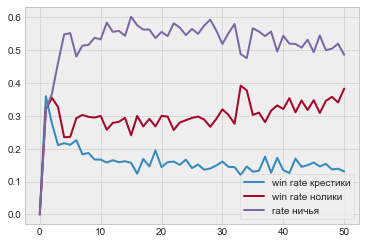

In [363]:
N_GAMES = 50_000

env = TicTacToe()
agents = {
    1: Agent(epsilon=0.1),
    -1: Agent(epsilon=0.1)
}
player_wins = {
    -1: 0,
    1: 0,
    0: 0
}
win_rates = [[0], [0], [0]]
for i in range(N_GAMES):
    result = play_episode(agents, env)
    player_wins[result] += 1
    
    if (i + 1) % 1_000 == 0:
        win_rates[0].append(player_wins[1] / 1_000)
        win_rates[1].append(player_wins[-1] / 1_000)
        win_rates[2].append(player_wins[0] / 1_000)
        
        player_wins = {
            -1: 0,
            1: 0,
            0: 0
        }
        
        plt.plot(win_rates[0], label='win rate крестики')
        plt.plot(win_rates[1], label='win rate нолики')
        plt.plot(win_rates[2], label='rate ничья')
        plt.legend()
        
        display.clear_output(wait=True)
        plt.show()

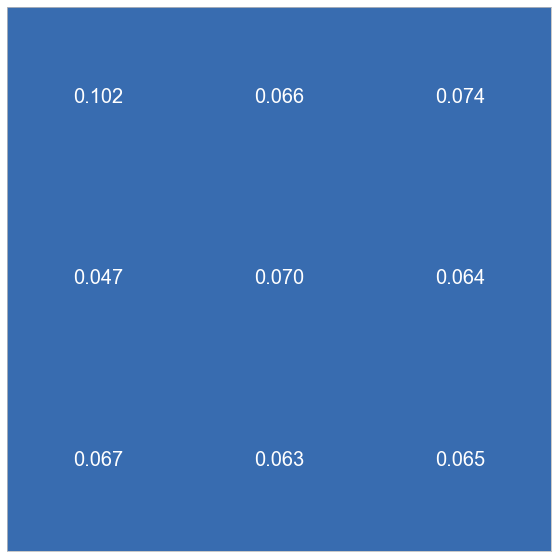

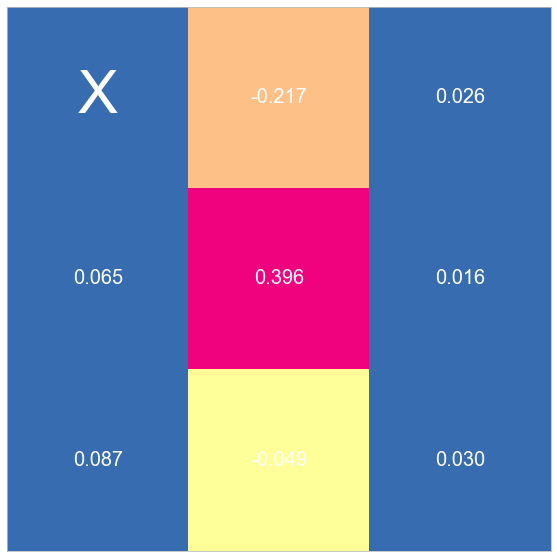

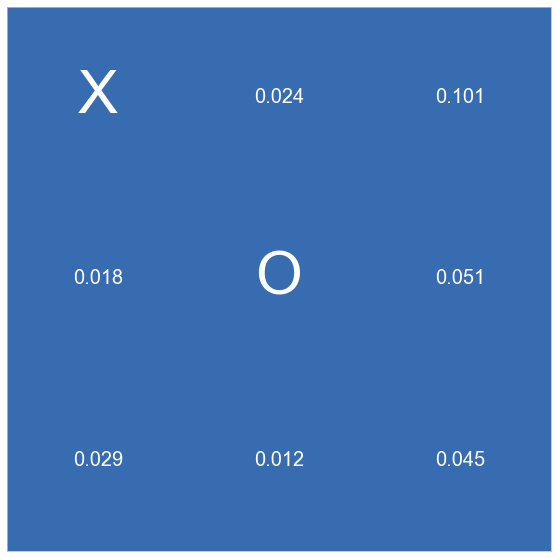

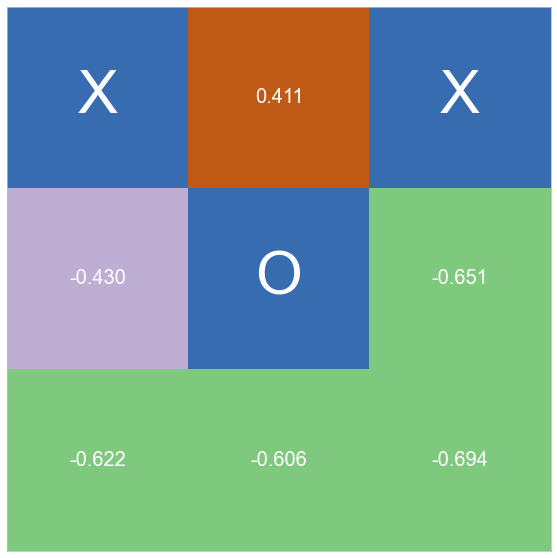

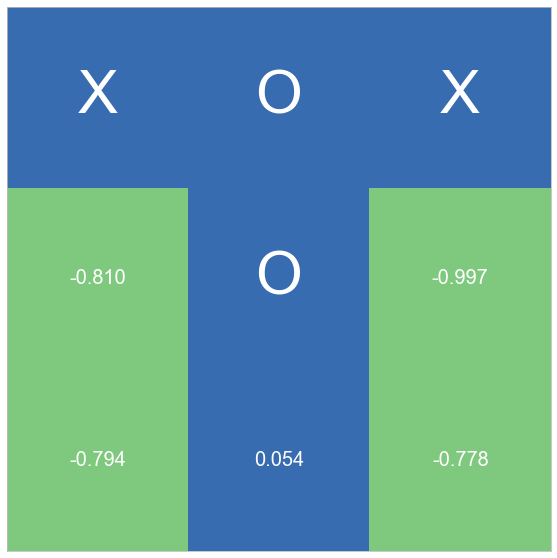

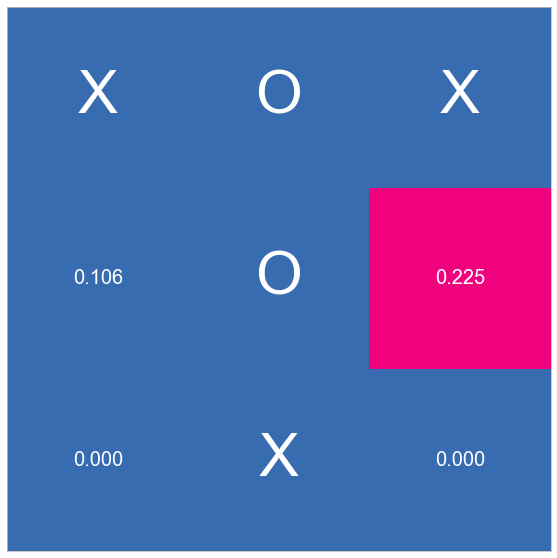

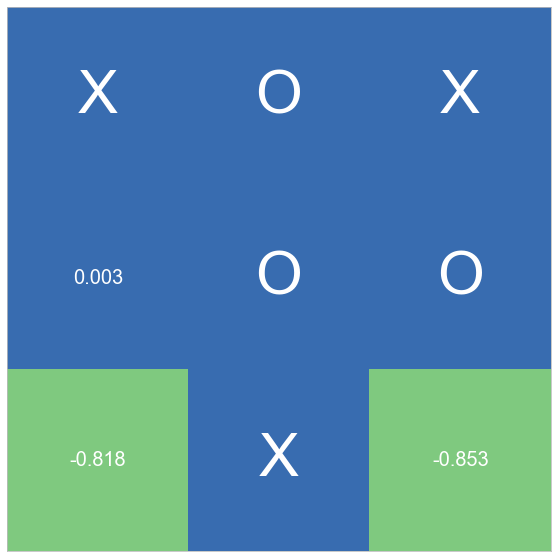

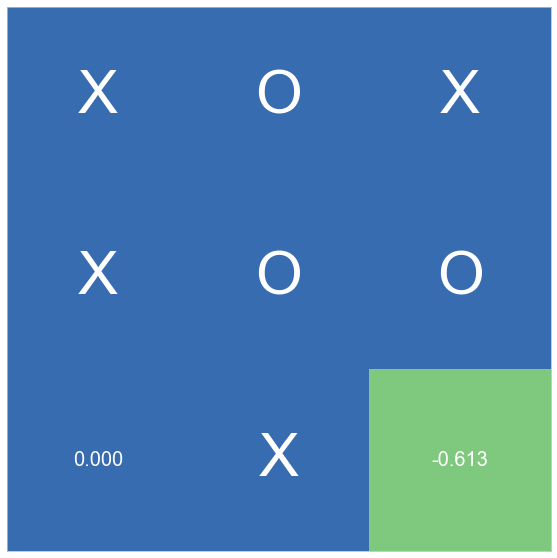

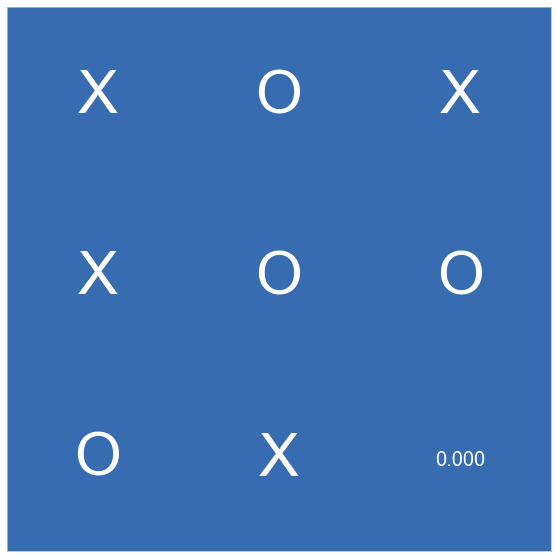

In [365]:
agents[1].epsilon = 0
agents[-1].epsilon = 0
plot_test_game(env, agents[1], agents[-1], verbose=False, random_naughts=False)

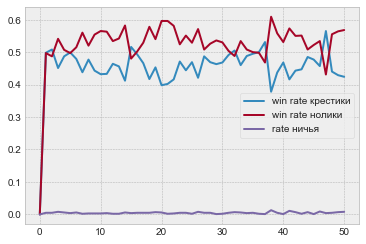

In [360]:
N_GAMES = 50_000

env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
agents = {
    1: Agent(epsilon=0.4),
    -1: Agent(epsilon=0.1)
}
player_wins = {
    -1: 0,
    1: 0,
    0: 0
}
win_rates = [[0], [0], [0]]
for i in range(N_GAMES):
    result = play_episode(agents, env)
    player_wins[result] += 1
    
    if (i + 1) % 1_000 == 0:
        win_rates[0].append(player_wins[1] / 1_000)
        win_rates[1].append(player_wins[-1] / 1_000)
        win_rates[2].append(player_wins[0] / 1_000)
        
        player_wins = {
            -1: 0,
            1: 0,
            0: 0
        }
        
        plt.plot(win_rates[0], label='win rate крестики')
        plt.plot(win_rates[1], label='win rate нолики')
        plt.plot(win_rates[2], label='rate ничья')
        plt.legend()
        
        display.clear_output(wait=True)
        plt.show()

## DQN

In [655]:
def pos_hash_to_tensor(pos_hash, dim):
    pos_x = [int(pos == '2') for pos in pos_hash]
    pos_o = [int(pos == '0') for pos in pos_hash]
    pos_space = [int(pos == '1') for pos in pos_hash]

    return torch.tensor([pos_x, pos_o, pos_space], dtype=torch.float32).reshape(3, dim, dim)

In [656]:
class DQN(nn.Module):
    def __init__(self, n_wins=3, n_rows=3, hidden_dim=32):
        nn.Module.__init__(self)
        
        self.conv = nn.Conv2d(3, hidden_dim, (n_wins, n_wins))
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, n_rows * n_rows)

    def forward(self, x):
        x = self.conv(x).relu()
        x = self.fc_1(x.flatten(1)).relu()
        x = self.fc_2(x)
        return x

In [657]:
class Memory:
    def __init__(self, capacity=100_000, n_rows=3):
        self.pos = 0
        self.n_samples = 0
        self.n_rows = n_rows
        self.capacity = capacity
        self.events = [(None, None, None, None) for _ in range(capacity)] # (prev_state, prev_action, next_state, reward)
    
    def save_event(self, prev_pos_hash, prev_action_id, cur_pos_hash, reward):
        prev_state = pos_hash_to_tensor(prev_pos_hash, self.n_rows)
        next_state = pos_hash_to_tensor(cur_pos_hash, self.n_rows)
        
        self.events[self.pos] = (prev_state, prev_action_id, next_state, reward)
        self.pos = (self.pos + 1) % self.capacity
        self.n_samples = min(self.capacity, self.n_samples + 1)
    
    def get_batch(self, batch_size):
        events = random.sample(self.events[:self.n_samples], batch_size)
        prev_states, prev_actions, next_states, rewards = zip(*events)
        return (torch.stack(prev_states), 
                torch.tensor(prev_actions).unsqueeze(1), 
                torch.stack(next_states),
                torch.tensor(rewards).unsqueeze(1)
               )

In [691]:
class AgentDQN:
    def __init__(self, epsilon=0.1, alpha=0.1, n_rows=3, train=False, batch_size=32):
        self.memory = Memory(n_rows=n_rows)
        self.n_rows = n_rows
        
        self.train = train
        self.q_model = DQN()
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=1e-4)
        self.batch_size = batch_size
        
        self.epsilon = epsilon
        self.alpha = alpha
        
        self.Q = {}

    def getAction(self, pos_hash, actions):
        r_action = np.random.randint(len(actions))
        action_id = actions[r_action][0] * self.n_rows + actions[r_action][1]
        
        if np.random.rand() >= self.epsilon:
            return self.getActionGreedy(pos_hash, len(actions))
        return action_id
        
    def getActionGreedy(self, pos_hash, n_actions):
        action_id = self.q_model(pos_hash_to_tensor(pos_hash, self.n_rows).unsqueeze(0)).argmax().item()
        return action_id
        
    def save_reward(self, prev_pos_hash, prev_action_id, cur_pos_hash, reward):
        self.memory.save_event(prev_pos_hash, prev_action_id, cur_pos_hash, reward)

    def learn_from_memory(self):
        if self.train and self.memory.n_samples > self.batch_size:
            self.optimizer.zero_grad()
            b_state, b_action, b_next_state, b_reward = self.memory.get_batch(self.batch_size)
        
            Q_pred = self.q_model(b_state).gather(1, b_action).reshape([self.batch_size])
            Q_true = b_reward + (self.alpha * self.q_model(b_next_state).detach().max(1)[0])
        
            loss = F.mse_loss(Q_true, Q_pred)

            loss.backward()
            self.optimizer.step()
            

In [692]:
def play_dqn_episode(agents, env):
    done = False
    env.reset()

    agents_prev_turn = {
        -1: [''.join('1' for _ in range(env.n_rows * env.n_cols)), 0],
        1: [''.join('1' for _ in range(env.n_rows * env.n_cols)), 0]
    } # (pos_hash, action_ind) for each Agent
    pos_hash, actions = env.getHash(), env.getEmptySpaces()

    while not done:
        agent_id = env.curTurn
        prev_agent_id = -agent_id
        
        action_pos = agents[agent_id].getAction(pos_hash, actions)
        agents_prev_turn[agent_id] = [pos_hash, action_pos]
        
        (pos_hash, actions, _), reward, done, _ = env.step(env.action_from_int(action_pos))
        if reward != -10 and agent_id == -1:
            reward *= -1
        
        agents[agent_id].save_reward(*agents_prev_turn[agent_id], pos_hash, reward)
        agents[prev_agent_id].save_reward(*agents_prev_turn[prev_agent_id], pos_hash, reward)

    for agent in agents.values():
        agent.learn_from_memory()

    return reward if reward == -10 else reward * agent_id

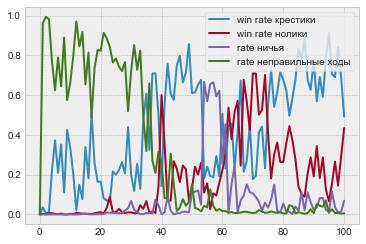

In [693]:
N_GAMES = 100_000

env = TicTacToe()
agents = {
    1: AgentDQN(train=True),
    -1: AgentDQN(train=True)
}
player_wins = {
    -1: 0,
    1: 0,
    0: 0,
    -10: 0
}
win_rates = [[0], [0], [0], [0]]
for i in range(N_GAMES):
    result = play_dqn_episode(agents, env)
    player_wins[result] += 1
    
    if (i + 1) % 1_000 == 0:
        win_rates[0].append(player_wins[1] / 1_000)
        win_rates[1].append(player_wins[-1] / 1_000)
        win_rates[2].append(player_wins[0] / 1_000)
        win_rates[3].append(player_wins[-10] / 1_000)
        
        
        player_wins = {
            -1: 0,
            1: 0,
            0: 0,
            -10: 0
        }
        
        plt.plot(win_rates[0], label='win rate крестики')
        plt.plot(win_rates[1], label='win rate нолики')
        plt.plot(win_rates[2], label='rate ничья')
        plt.plot(win_rates[3], label='rate неправильные ходы')
        plt.legend()
        
        display.clear_output(wait=True)
        plt.show()

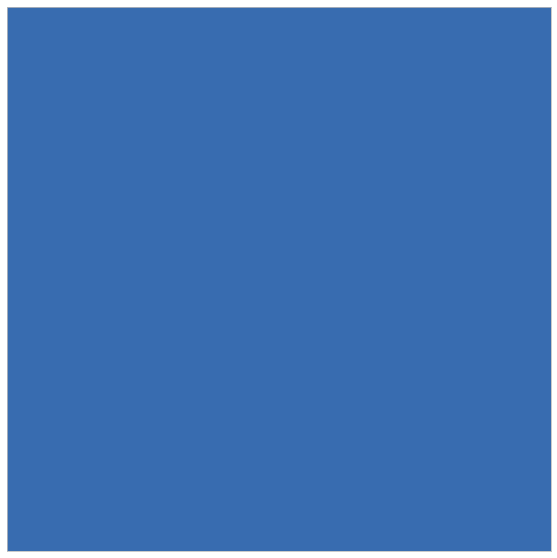

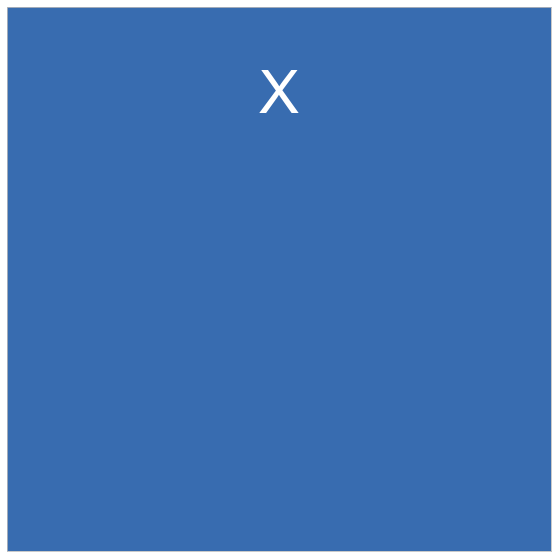

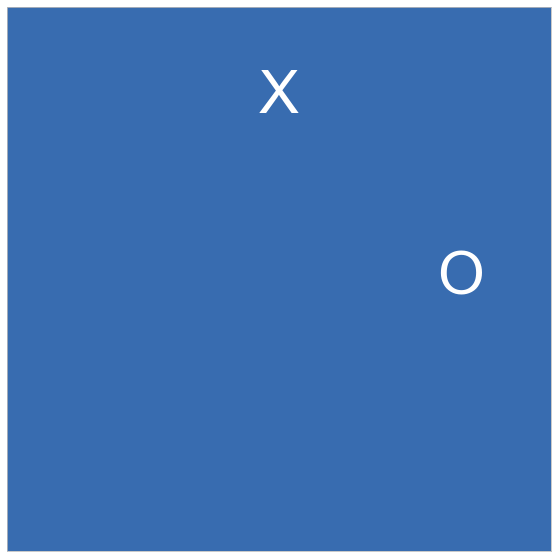

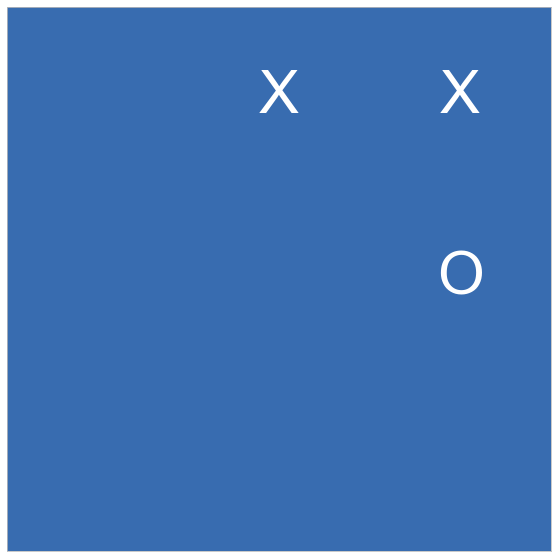

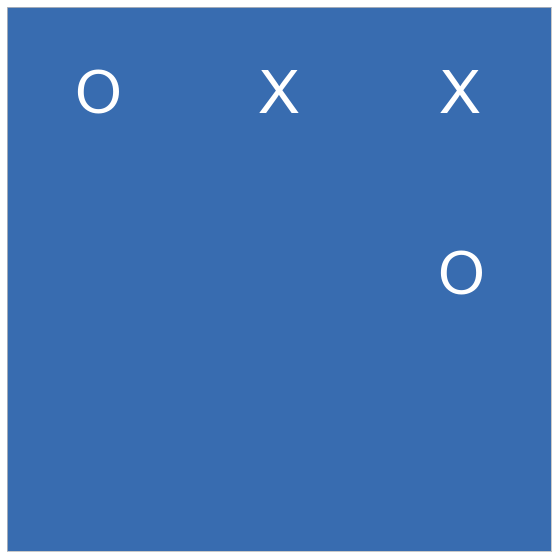

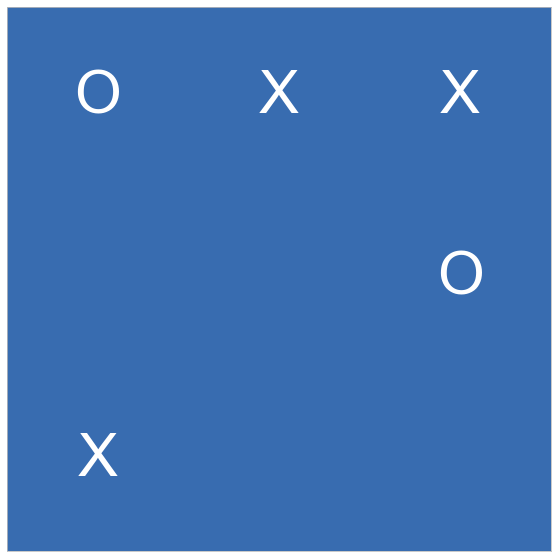

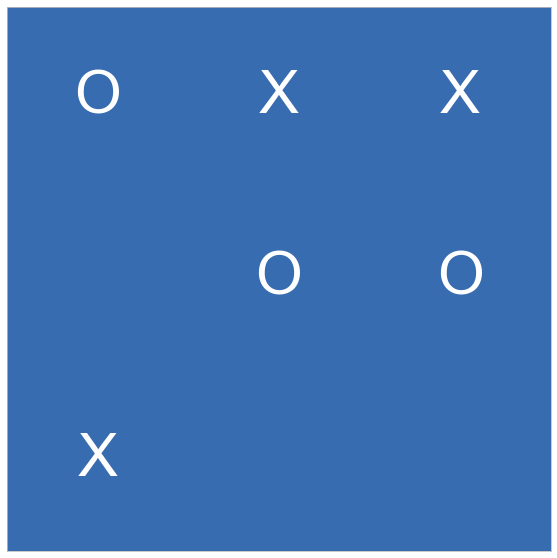

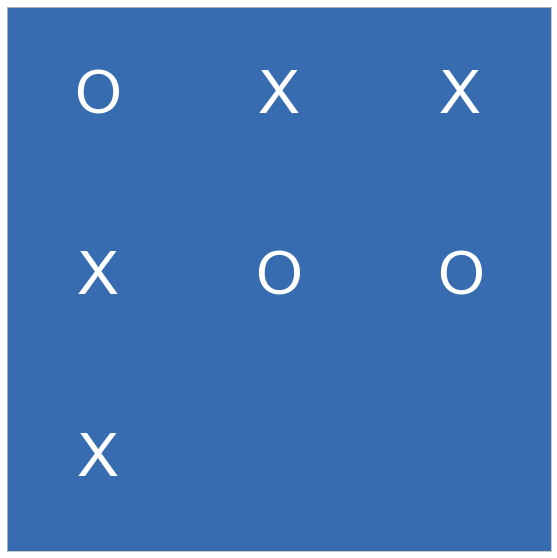

Нолики выиграли!


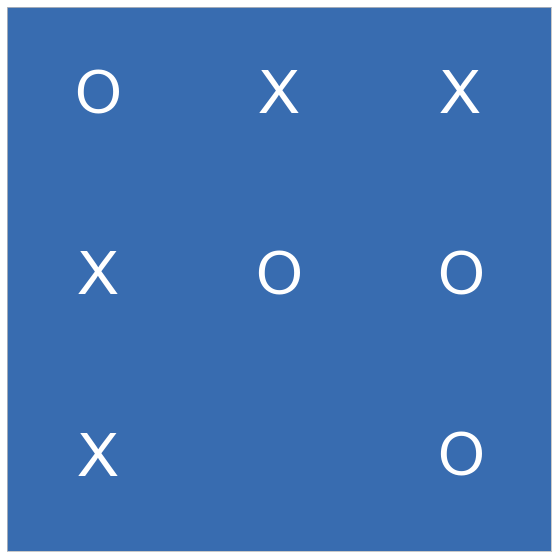

In [702]:
agents[1].train = False
agents[-1].train = False
plot_test_game(env, agents[1], agents[1], verbose=False, random_naughts=False, dqn=True)